In [1]:
# 以沪深300数据集为例，构建特征和目标值，拟合特征与目标值，并评估模型
# 数据已经经过了初步清洗，剔除掉每天的涨跌停股和ST股，并使用后复权价格
# 如果不做回测，可以注释掉一切带"_test"的行

import pandas as pd
from scutquant import scutquant, alpha

In [2]:
# 读取数据
df_train = pd.read_csv('D:/Desktop/CSI300.csv')
df_test = pd.read_csv('D:/Desktop/CSI300_test.csv')
df_train.set_index(['datetime', 'instrument'], inplace=True)
df_test.set_index(['datetime', 'instrument'], inplace=True)

df = pd.concat([df_train, df_test], axis=0)
df

open       close        high         low  \
datetime   instrument                                                   
2010-01-04 300003.SZ    51.590000   51.500000   51.850000   51.100000   
           300014.SZ    39.700000   39.470000   39.900000   39.240000   
           300015.SZ    48.970000   48.770000   49.190000   48.550000   
           300033.SZ    72.010000   74.570000   76.060000   71.610000   
           600000.SH    64.829142   62.928517   64.947931   62.839425   
...                           ...         ...         ...         ...   
2022-12-23 688363.SH   130.338644  130.842543  133.513211  129.078895   
           688396.SH    53.248294   52.735905   54.052042   52.344078   
           688561.SH    61.590000   67.160000   68.190000   61.590000   
           688599.SH    55.856185   54.938671   56.263968   53.909017   
           688981.SH    40.900000   41.060000   41.330000   40.830000   

                           volume        amount  
datetime   instrument                            
2010-01-04 300003.SZ     842437.0  4.328901e+07  
           300014.SZ     727706.0  2.873182e+07  
           300015.SZ     740314.0  3.613862e+07  
           300033.SZ    3627417.0  2.702477e+08  
           600000.SH   66191338.0  1.419984e+09  
...                           ...           ...  
2022-12-23 688363.SH    2334792.0  3.036193e+08  
           688396.SH    3462319.0  1.820840e+08  
           688561.SH    3554834.0  2.353862e+08  
           688599.SH   10072858.0  5.395502e+08  
           688981.SH    7428877.0  3.055459e+08  

[651282 rows x 6 columns]

In [3]:
# 清洗数据(由于原始数据已经经过了初步清洗，所以以下步骤可以省去)

# 查看缺失值和数据类型
df.info()
# 查看是否存在异常数据
#df.describe()
# 处理缺失值
#df.dropna(axis=1, how='all', inplace=True)  # 去除掉全为缺失值的列
#df = df.groupby(['instrument']).fillna(method='ffill').dropna()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 651282 entries, ('2010-01-04', '300003.SZ') to ('2022-12-23', '688981.SH')
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    651282 non-null  float64
 1   close   651282 non-null  float64
 2   high    651282 non-null  float64
 3   low     651282 non-null  float64
 4   volume  651282 non-null  float64
 5   amount  651282 non-null  float64
dtypes: float64(6)
memory usage: 32.4+ MB


In [4]:
# 下面开始构造目标值和特征

df['label'] = scutquant.price2ret(df['close'], shift1=-1, shift2=-2, groupby='instrument')

feature_kwargs = {
    'data': df,
    'price': 'close',
    'label': 'label',
    'last_close': 'open',
    'volume': 'volume',
    'amount': 'amount',
    'high': 'high',
    'low': 'low',
    'shift': 2,
    'groupby': 'instrument'
}
features = alpha.make_factors(feature_kwargs, windows=[5, 10, 20, 30, 60])
X = pd.concat([features, df['label']], axis=1)

X.describe()

,ma5,std5,max5,min5,beta5,roc5,ma10,std10,max10,min10,...,rsv10,rsv20,rsv30,rsv60,klen5,klen10,klen20,klen30,klen60,label
count,649422.000000,649422.000000,649422.000000,649422.000000,650662.000000,6.506620e+05,647872.000000,647872.000000,647872.000000,647872.000000,...,648492.000000,645392.000000,642292.000000,632992.000000,650042.000000,648492.000000,645392.000000,642292.000000,632992.000000,650662.000000
mean,0.001139,0.027136,0.036448,-0.031185,0.000004,-9.441242e+04,0.001148,0.028800,0.052621,-0.043396,...,12.950646,12.897034,12.845541,12.657972,0.034986,0.034986,0.035005,0.035034,0.035124,0.001135
std,0.016968,0.031020,0.061755,0.033825,0.011583,4.080188e+07,0.011593,0.029199,0.081823,0.041043,...,73.254734,72.982316,72.850301,71.642050,0.016861,0.015727,0.014814,0.014334,0.013537,0.040568
min,-0.173861,0.000000,-0.079832,-0.800138,-1.000408,-3.793733e+09,-0.090841,0.001039,-0.011142,-0.800138,...,-0.999744,-0.999736,-0.999736,-0.999725,0.001666,0.003968,0.005229,0.005450,0.005886,-0.800138
25%,-0.005933,0.013124,0.012513,-0.038443,-0.004065,-2.033447e+00,-0.003902,0.015377,0.021991,-0.052005,...,-0.815811,-0.816737,-0.817311,-0.819934,0.022901,0.023718,0.024393,0.024754,0.025437,-0.012942
50%,0.000216,0.020510,0.024430,-0.022871,-0.000004,-1.000000e+00,0.000385,0.022625,0.036644,-0.032723,...,-0.089285,-0.093664,-0.099214,-0.114001,0.032174,0.032700,0.033067,0.033275,0.033691,0.000000
75%,0.006940,0.032053,0.043512,-0.012720,0.004012,-2.523656e-02,0.005140,0.033621,0.060236,-0.020873,...,4.149272,4.124968,4.100062,4.023037,0.043721,0.043438,0.043270,0.043163,0.042993,0.012839
max,1.012244,2.259588,5.026166,0.077165,0.992330,9.775391e+09,0.507849,1.593394,5.026166,0.015585,...,6378.559821,6654.432678,6708.836760,6820.357592,0.184640,0.158079,0.138242,0.124034,0.110373,5.026166


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 580608 entries, ('2010-01-04', '300003.SZ') to ('2021-12-31', '688981.SH')
Columns: 106 entries, ma5 to label
dtypes: float64(106)
memory usage: 471.9+ MB
None
X_mis= 0.9881671211024592
clean dataset done 

pop label done 

label norm done 



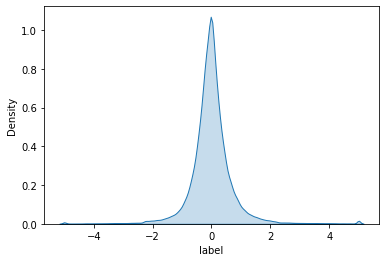

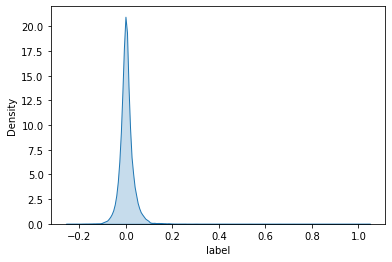

norm data done 

min60     0.109750
max60     0.106404
min30     0.093611
max30     0.093320
max20     0.089291
            ...   
risk30    0.000000
ksft30    0.000000
kmid10    0.000000
risk10    0.000000
klen5     0.000000
Name: MI Scores, Length: 105, dtype: float64
count    105.000000
mean       0.030950
std        0.029792
min        0.000000
25%        0.005941
50%        0.023542
75%        0.060221
max        0.109750
Name: MI Scores, dtype: float64
kmid30 will be dropped
risk30 will be dropped
ksft30 will be dropped
kmid10 will be dropped
risk10 will be dropped
klen5 will be dropped
all works done 



In [5]:
# 先拆分出测试集，然后做特征工程、数据清洗，并根据mutual information score选择特征

X_test = X[X.index.isin(df_test.index)]
X = X[~X.index.isin(df_test.index)]

# 使用auto_process()自动处理训练集和验证集(将在以后的版本完善拆分数据集的函数，使其能够同时处理训练、验证和测试集)
# select需要消耗大量时间，但可以过滤掉噪声。使用时需要在时间开销和模型性能之间权衡
x_train, x_valid, y_train, y_valid, ymean, ystd = scutquant.auto_process(X, 'label', groupby='instrument', select=True)

In [6]:
# 手动处理测试集
X_test = X_test.groupby(['instrument']).fillna(method='ffill').dropna()
x_test = X_test.copy()
y_test = x_test.pop('label')
col = x_train.columns
x_test = x_test[col]
x_test = scutquant.zscorenorm(x_test)

In [7]:
x_train.head(5)

ma5      std5      max5      min5     beta5  \
datetime   instrument                                                     
2010-04-07 600009.SH  -0.182029 -0.525459 -0.408591  0.507034  0.227800   
           600010.SH   0.485957 -0.397709 -0.186691  0.612031 -0.545700   
           600015.SH  -0.059756 -0.404583 -0.231276  0.431386  0.218864   
           600016.SH  -0.240460 -0.527145 -0.435545  0.485990  0.264899   
           600018.SH  -0.110743 -0.623033 -0.445208  0.625406  0.084019   

                           roc5      ma10     std10     max10     min10  ...  \
datetime   instrument                                                    ...   
2010-04-07 600009.SH   0.002537 -0.095416 -0.476526 -0.282187  0.542178  ...   
           600010.SH   0.002537  0.325286 -0.507239 -0.328288  0.786229  ...   
           600015.SH   0.002537  0.562972 -0.134749  0.034145  0.639451  ...   
           600016.SH   0.002537  0.170488 -0.410963 -0.181242  0.669201  ...   
           600018.SH   0.002537 -0.017177 -0.623582 -0.401861  0.715827  ...   

                          hml60      rsv5     rsv10     rsv20     rsv30  \
datetime   instrument                                                     
2010-04-07 600009.SH  -0.169577 -0.183013 -0.183130 -0.183485 -0.183197   
           600010.SH  -0.168366 -0.189800 -0.189690 -0.190161 -0.189958   
           600015.SH  -0.164519 -0.188409 -0.188203 -0.188756 -0.188541   
           600016.SH  -0.160601 -0.177596 -0.177370 -0.177854 -0.177552   
           600018.SH  -0.158036 -0.179389 -0.179142 -0.179630 -0.179387   

                          rsv60    klen10    klen20    klen30    klen60  
datetime   instrument                                                    
2010-04-07 600009.SH  -0.181011 -0.294499  0.004310  0.284638  0.214058  
           600010.SH  -0.188373 -0.345190 -0.029735  0.217449  0.216871  
           600015.SH  -0.186837 -0.443268 -0.084837  0.181559  0.233272  
           600016.SH  -0.174870 -0.335206 -0.059956  0.180402  0.258907  
           600018.SH  -0.176820 -0.341146 -0.064774  0.157807  0.270886  

[5 rows x 99 columns]

In [8]:
# 拟合模型

xgb_params = {
    'est': 800,
    'eta': 0.0421,
    'colsamp': 0.8875,
    'subsamp': 0.8725,
    'max_depth': 6,
    'l1': 45,
    'l2': 50,
    'early_stopping_rounds': 20
}
model = scutquant.hybrid(lrg_method='ridge', xgb_params=xgb_params, weight=[0.3, 0.7])
model.fit(x_train, y_train, x_valid, (y_valid-ymean)/ystd)

pred = model.predict(x_test)
pred = pd.DataFrame({'predict': pred}, index=x_test.index)
pred += ymean
pred *= ystd

pred

[0]	validation_0-rmse:0.83843
[1]	validation_0-rmse:0.82694
[2]	validation_0-rmse:0.81649
[3]	validation_0-rmse:0.80642
[4]	validation_0-rmse:0.79707
[5]	validation_0-rmse:0.78857
[6]	validation_0-rmse:0.78061
[7]	validation_0-rmse:0.77322
[8]	validation_0-rmse:0.76644
[9]	validation_0-rmse:0.76023
[10]	validation_0-rmse:0.75448
[11]	validation_0-rmse:0.74919
[12]	validation_0-rmse:0.74441
[13]	validation_0-rmse:0.73997
[14]	validation_0-rmse:0.73589
[15]	validation_0-rmse:0.73206
[16]	validation_0-rmse:0.72856
[17]	validation_0-rmse:0.72530
[18]	validation_0-rmse:0.72247
[19]	validation_0-rmse:0.71982
[20]	validation_0-rmse:0.71734
[21]	validation_0-rmse:0.71497
[22]	validation_0-rmse:0.71289
[23]	validation_0-rmse:0.71098
[24]	validation_0-rmse:0.70914
[25]	validation_0-rmse:0.70751
[26]	validation_0-rmse:0.70606
[27]	validation_0-rmse:0.70471
[28]	validation_0-rmse:0.70348
[29]	validation_0-rmse:0.70239
[30]	validation_0-rmse:0.70138
[31]	validation_0-rmse:0.70043
[32]	validation_0-

predict
datetime   instrument          
2022-01-04 000001.SZ   0.003039
           000002.SZ  -0.000533
           000063.SZ   0.002477
           000066.SZ   0.001448
           000069.SZ   0.000980
...                         ...
2022-12-23 688363.SH   0.000394
           688396.SH   0.002486
           688561.SH  -0.002341
           688599.SH   0.002526
           688981.SH   0.000314

[70549 rows x 1 columns]

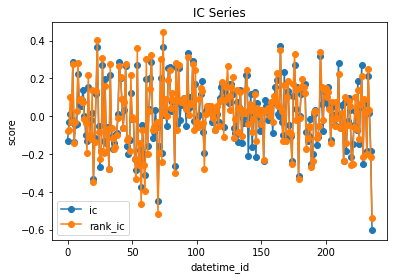

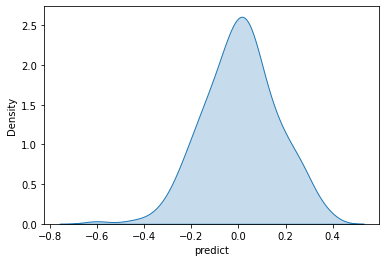

ic= 0.006668300454511846 icir= 0.04234663474568861 rank_ic= 0.012552860002599489 rank_icir= 0.0748083855887615


In [9]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = scutquant.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)

In [10]:
# 使用pearson相关系数评判拟合优度
r = scutquant.pearson_corr(pred.values, y_test)
r

array([0.02719179])

In [11]:
# 以下为回测部分
from scutquant import executor

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df, time='datetime', price='close')

# 无底仓时只用设置cash，剩余的会自动设置
acc={
    'cash': 1000000000,
    'position': None,
    'available': None,
    'ben_position': None,
}
exe = executor.Executor(generator={'mode': 'generate'}, acc=acc, cost_buy=0.0015, cost_sell=0.0005, min_cost=5, risk_degree=0.95, 
                        auto_offset=True, offset_freq=2, buy_only=True)
exe.execute(data=pred, verbose=0)

E(r): -0.05066677168883724
std: 0.01882648280887836
E(r_benchmark): -0.13770665127800302
std_benchmark: 0.05320053573200636 

Cumulative Rate of Return: -0.062308347706432454
Cumulative Rate of Return(benchmark): -0.19375655308159512
Cumulative Excess Rate of Return: 0.13144820537516266 

Max Drawdown: -0.08812296322448787
Max Drawdown(benchmark): -0.23812980368328573 

Sharpe Ratio: -2.6956157443134576
Information Ratio: 4.623268215989805


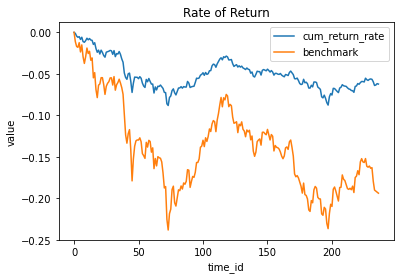

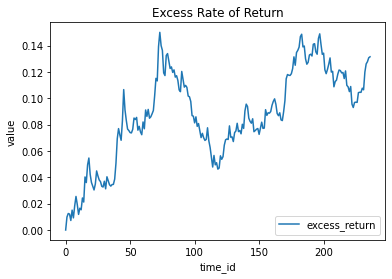

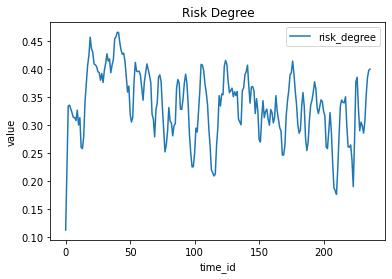

In [12]:
# 报告回测结果
# 对比2022年主动管理型基金的业绩，这表现算是在平均线以上
from scutquant import report

user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365)  # 无风险收益率默认为年化3%，可以通过参数rf调节

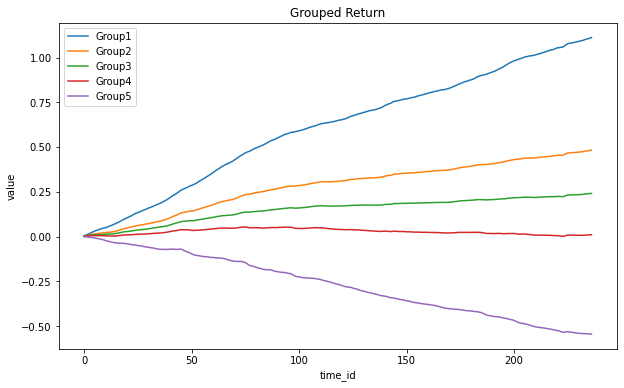

In [13]:
# 出现明显的分层, 说明因子有良好的选股能力
report.group_return_ana(pred)